In [184]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np

### 1.Рассмотрим датасет

In [185]:
df = pd.read_csv('C:/Users/User/PycharmProjects/pythonProject3/HR Employee Attrition.csv')
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


<AxesSubplot:>

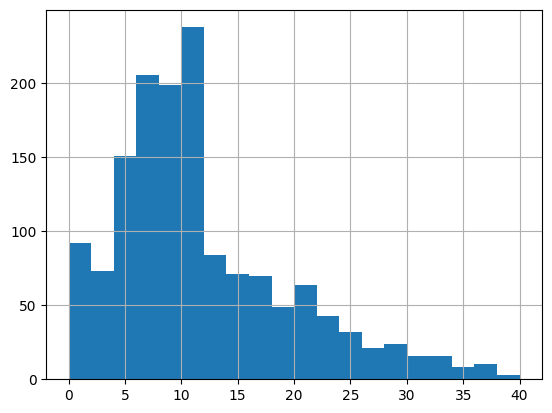

In [186]:
df.TotalWorkingYears.hist(bins=20)

### 2. Построим ядерную оценку плотности для столбца *TotalWorkingYears*

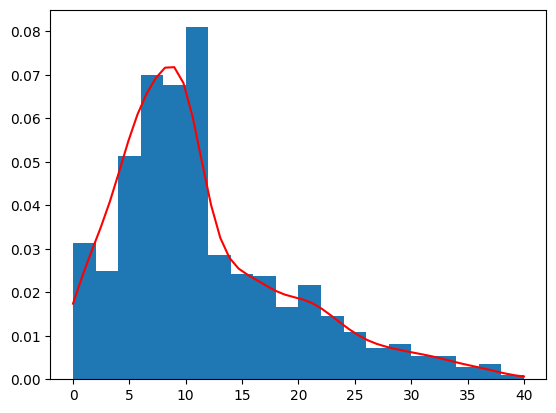

In [187]:
from scipy.stats import gaussian_kde
x = df.TotalWorkingYears.to_numpy()
density = gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max())
plt.hist(x, bins=20, density=True)
plt.plot(xgrid, density(xgrid), 'r-')

### 3. Оценка квантилей
    Построим гистрограмму и ящик с усами, по нему видны выбросы, которые далее отсечем. 
    Также ниже приведена таблица квантилей

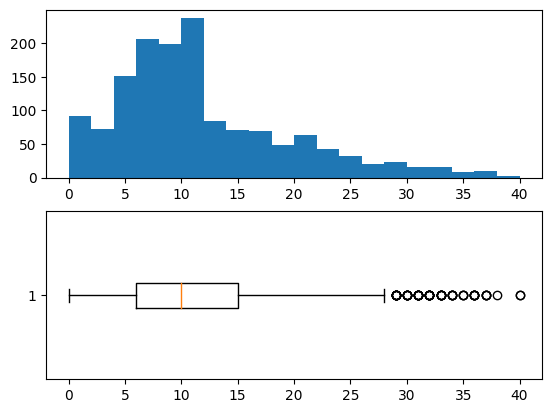

In [188]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.hist(x, bins=20)

plt.subplot(2,1,2)
plt.boxplot(x, vert=False)
plt.show()

In [189]:
q = {}
arr = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in arr:
    q[i] = pd.Series(np.quantile(x, i))
quantile = pd.DataFrame(q)
quantile

,0.10,0.25,0.50,0.75,0.90
0,3.0,6.0,10.0,15.0,23.0


In [190]:
clear_data = []
for i in x:
    if i < 30:
        clear_data.append(i)

In [191]:
clear_data = np.array(clear_data)
clear_data.min()

0

### 4. Оценка неизвестных параметров
    В качестве теоретических распределений будут сравнены гамма и логнормальное
    Оценим параметры с помощью ММП, использую встроенную функцию fit
    Результаты приведены на рисунке ниже. Сравнение гистограммы и теоретической оценки двумя распределениями

In [192]:
from scipy.stats import gamma, lognorm

param_gamma = gamma.fit(df.TotalWorkingYears)
param_log = lognorm.fit(df.TotalWorkingYears)

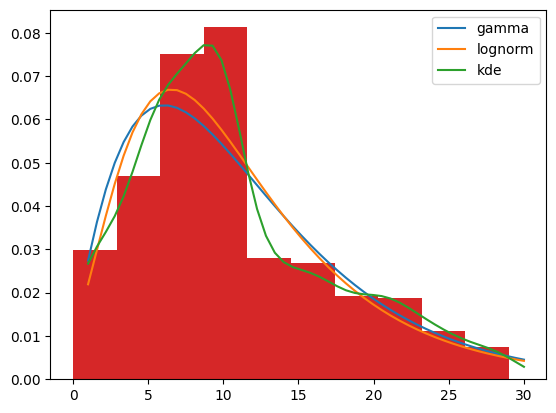

In [193]:
y = [gamma.pdf(i, param_gamma[0], param_gamma[1], param_gamma[2]) for i in np.linspace(1,30)]
z = [lognorm.pdf(i, param_log[0], param_log[1], param_log[2]) for i in np.linspace(1,30)]

x_grid = np.linspace(1,30)
plt.plot(x_grid, y, label='gamma')
plt.plot(x_grid, z, label='lognorm')

density = gaussian_kde(clear_data)
plt.plot(x_grid, density(x_grid), label='kde')
plt.hist(clear_data, bins=10, density=True)

plt.legend()
plt.show()

    Для обучения МНК необходимо получить дискретизированные данные исходной выборки. 
    Для обучения используем curve_fit

In [194]:
ydata, xdata = np.histogram(clear_data, bins=25, density=True)
def g(t, p0, p1, p2):
    
    return gamma.pdf(t, p0, p1, p2)

p = scipy.optimize.curve_fit(g, xdata[1:], ydata)
p[0]

array([10.74944146, -8.65744133,  1.72351668])

### 6.Проверка
     Сравним два полученных теоретических гамма-распредления (ММП и МНК) с помощью квантильных биплотов. Для ММП точки лежат на прямой, однако с увеличением значений выборки они начинают расходится. Для МНК график не ровный

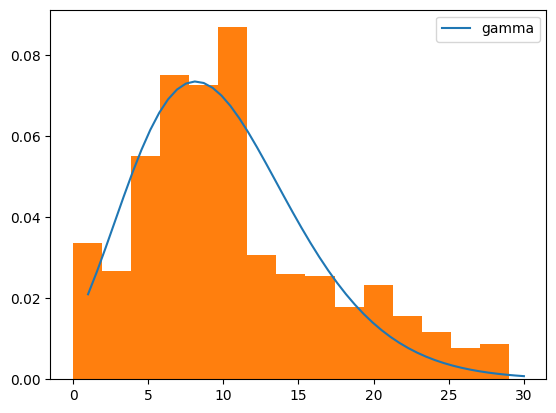

In [195]:
k = [gamma.pdf(i, p[0][0], p[0][1], p[0][2]) for i in np.linspace(1,30)]
plt.plot(x_grid, k, label='gamma')
plt.hist(clear_data, bins=15, density=True)
plt.legend()
plt.show()

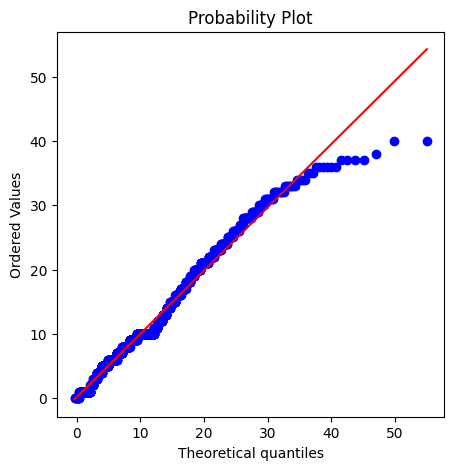

In [196]:
figure, ax = plt.subplots(1, 1, figsize=(5, 5))
scipy.stats.probplot(df.TotalWorkingYears, dist=gamma, sparams=(param_gamma[0], param_gamma[1], param_gamma[2]), plot=ax)
plt.show()

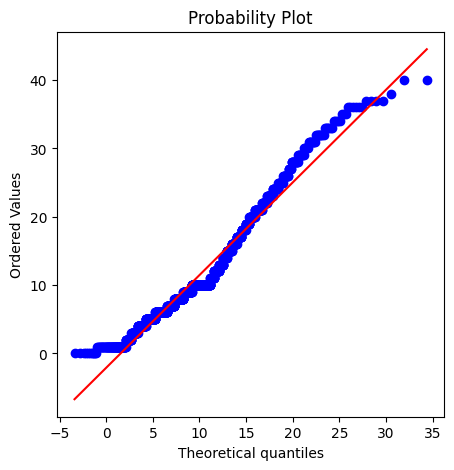

In [197]:
figure, ax = plt.subplots(1, 1, figsize=(5, 5))
scipy.stats.probplot(df.TotalWorkingYears, dist=gamma, sparams=(p[0][0], p[0][1], p[0][2]), plot=ax)
plt.show()

### 7. Тесты
    Проведем 2 статистических теста - Колмогорова-Смирнова и Крамера фон Мизеса. Оба они показывает низкий p-value, что не дает возможности сказать, что данные распределены именно таким образом

In [198]:
from scipy.stats import kstest, chisquare, cramervonmises

param_ks1 = kstest(clear_data, cdf='lognorm', args=param_log)
param_ks2 = kstest(clear_data, cdf='gamma', args=param_gamma)

param_log1 = cramervonmises(clear_data, cdf='gamma', args=param_gamma)
param_log2 = cramervonmises(clear_data, cdf='lognorm', args=param_log)
print(param_log1)
print(param_log2)
print(param_ks1)
print(param_ks2)

CramerVonMisesResult(statistic=2.3448347569564594, pvalue=2.129299917053018e-06)
CramerVonMisesResult(statistic=1.883057775245204, pvalue=2.3209919970179627e-05)
KstestResult(statistic=0.12385112841914214, pvalue=2.108041542033689e-19)
KstestResult(statistic=0.12917156081903192, pvalue=4.5056498628303784e-21)


### 8. Проведем сэмплирование из полученных теоретических распределений.
    Для этого используется метод кубической интерполяции и метод отношений униформ

In [199]:
from scipy.stats.sampling import NumericalInverseHermite, SimpleRatioUniforms

class Gamma():
    def __init__(self, param):
        self.param = param
    def pdf(self, x):
       return gamma.pdf(x, self.param[0], self.param[1], self.param[2])
    def cdf(self, x):
       return gamma.cdf(x, self.param[0], self.param[1], self.param[2])

dist = Gamma(param_gamma)
a = NumericalInverseHermite(dist=dist)
b = SimpleRatioUniforms(dist=dist)
l1 = a.rvs(size=100)
l2 = b.rvs(size=100)

C:\Users\User\AppData\Local\Temp\ipykernel_12372\2038114948.py:13: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  b = SimpleRatioUniforms(dist=dist)


(array([0.03826882, 0.03316631, 0.04847384, 0.05357635, 0.03316631,
        0.01530753, 0.01275627, 0.00510251, 0.00765376, 0.00765376]),
 array([-0.36270577,  3.55693439,  7.47657455, 11.3962147 , 15.31585486,
        19.23549502, 23.15513518, 27.07477534, 30.99441549, 34.91405565,
        38.83369581]),
 <BarContainer object of 10 artists>)

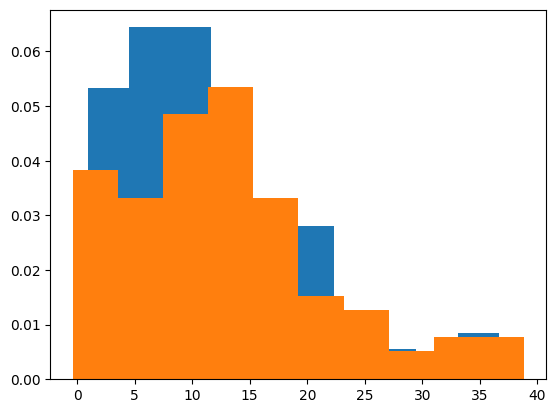

In [200]:
plt.hist(l1, bins=10, density=True)
plt.hist(l2, bins=10, density=True)

### Для второй выборки используем столбец Age

In [201]:
x = df.Age.to_numpy()

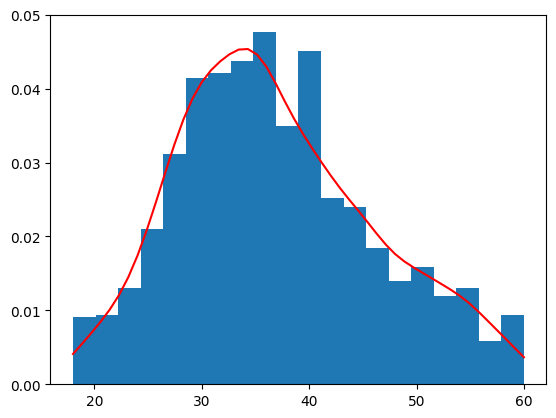

In [202]:
from scipy.stats import gaussian_kde

density = gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max())
plt.hist(x, bins=20, density=True)
plt.plot(xgrid, density(xgrid), 'r-')

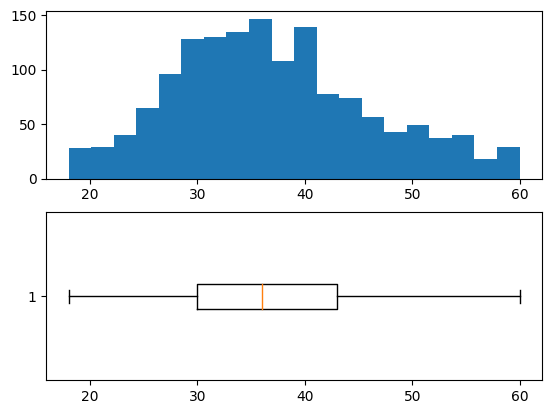

In [203]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.hist(x, bins=20)

plt.subplot(2,1,2)
plt.boxplot(x, vert=False)
plt.show()

In [226]:
q = {}
arr = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in arr:
    q[i] = pd.Series(np.quantile(x, i))
quantile = pd.DataFrame(q)
quantile

,0.10,0.25,0.50,0.75,0.90
0,1.0,2.0,7.0,14.0,23.0


### Оценим неизвестные параметры
    Здесь я считаю метод максимального правдоподобия вручную.

In [204]:
from math import log, sqrt

y = df.Age.to_numpy()
mean_log = np.array([log(i) for i in y])
alpha = mean_log.mean()
print(alpha)
mean_log = mean_log ** 2
mean = mean_log.mean()
sigma = mean - (alpha ** 2)
sigma = sqrt(sigma)
print(sigma)

3.578033693266757
0.25011952311200863


In [205]:
from math import exp,pi
def lognorm(t, a, b):
    return (1/(t*b*sqrt(2*pi)))*exp(-(log(t) - a)**2 / (2*b**2))

Можно нарисовать график логнормального распределения с получившимися параметрами вместе с гистрограммой.
Можно видеть, что визуально он неплохо приближает данные

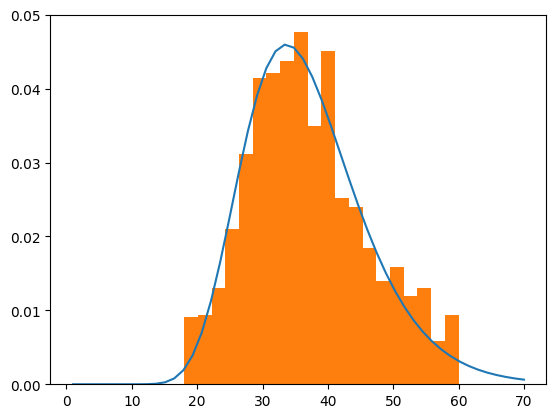

In [206]:
y = [lognorm(i, alpha, sigma) for i in np.linspace(1,70)]
plt.plot(np.linspace(1,70), y)
plt.hist(df.Age, bins=20, density=True)
plt.show()

Теперь обучим методом наименьших квадратов. Для этого представим исходную выборку как дискретное распределение. И для каждого значения из выборки посчитаем колчисвто раз, которое оно встречается в ней. Получится своего рода функция вероятности. Используем её для подгона параметров. Можно видеть, что результаты, полученные МНК очень близки к результатам ММП

In [207]:
x.sort()
size = len(x)
def prob(x):
    probabilities = []
    rep = 1
    for i in range(len(x) - 1):
        if x[i + 1] == x[i]:
            rep += 1
        else:
            probabilities.append(rep)
            rep = 1
    probabilities.append(rep)
    return probabilities
y = prob(x)
y = np.array(y) / size
x = np.unique(x)
x

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

In [208]:
def logn(t, a, b):
    return (1/(t*b*np.sqrt(2*pi)))*np.exp(-(np.log(t) - a)**2 / (2*b**2))
param, p = scipy.optimize.curve_fit(logn, x, y)
param

array([3.58126208, 0.25844732])

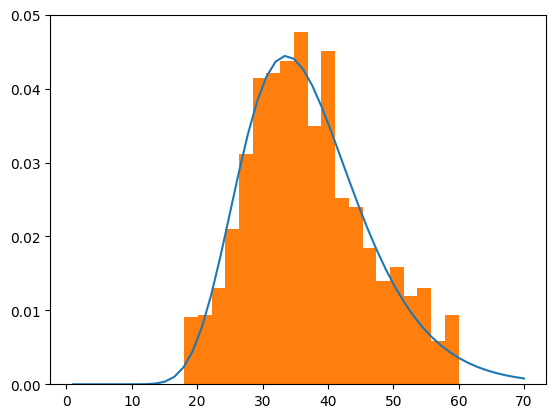

In [209]:
y = [lognorm(i, param[0], param[1]) for i in np.linspace(1,70)]
plt.plot(np.linspace(1,70), y)
plt.hist(df.Age, bins=20, density=True)
plt.show()

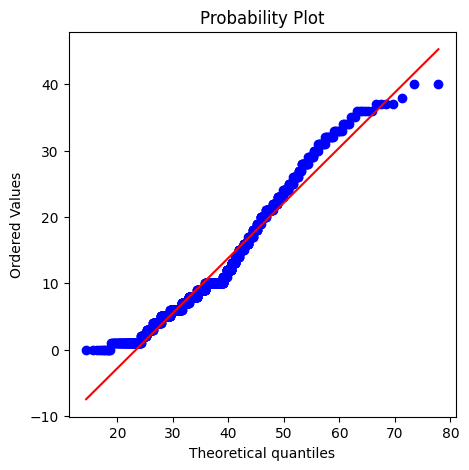

In [211]:
figure, ax = plt.subplots(1, 1, figsize=(5, 5))
scipy.stats.probplot(df.TotalWorkingYears, dist=logn, sparams=(alpha, sigma), plot=ax)
plt.show()

### Проведем тесты для получившегося вручную распределения
    Будем использовать те же тесты, что для предыдущей выборки, только двухпараметрические.
    Сделаем сэмплинг из распределения с получившимися параметрами для и сравним две выборки.
    Нулевая гипотеза в данном случае - что выборки из одного распределения. Если гипотеза верна, то и исходная выборка из этого распределения

In [212]:
from scipy.stats import kstest, chisquare, cramervonmises_2samp, cramervonmises, lognorm

x = df.Age.to_numpy()
y = np.random.lognormal(alpha, sigma, 20070)

p = kstest(x, y)
p

KstestResult(statistic=0.03388446559490754, pvalue=0.08409861846117928)

In [213]:
x = df.Age.to_numpy()
y = np.random.lognormal(alpha, sigma, 20070)
r = cramervonmises_2samp(x, y)
r

CramerVonMisesResult(statistic=0.25304690244752237, pvalue=0.18449589126552057)

В обоих случаях результаты значения p-value получаются больше 0.05. Можно принять нулевую гипотезу

In [214]:
class Logn:
    def __init__(self, alpha, sigma):
        self.alpha = alpha
        self.sigma = sigma
    def pdf(self, x):
       return logn(x, alpha, sigma)
    def cdf(self, x):
       return logn(x, alpha, sigma)

dist = Logn(alpha, sigma)
a = NumericalInverseHermite(dist=dist)
l = a.rvs(size=100)
l

C:\Users\User\AppData\Local\Temp\ipykernel_12372\2096746772.py:2: RuntimeWarning: invalid value encountered in log
  return (1/(t*b*np.sqrt(2*pi)))*np.exp(-(np.log(t) - a)**2 / (2*b**2))
C:\Users\User\AppData\Local\Temp\ipykernel_12372\3934900800.py:11: RuntimeWarning: [objid: HINV.016] 32 : cannot find l.h.s. of domain => (distribution) desired property does not exist
  a = NumericalInverseHermite(dist=dist)
C:\Users\User\AppData\Local\Temp\ipykernel_12372\3934900800.py:11: RuntimeWarning: [objid: HINV.016] 32 : cannot find r.h.s. of domain => (distribution) desired property does not exist
  a = NumericalInverseHermite(dist=dist)
C:\Users\User\AppData\Local\Temp\ipykernel_12372\2096746772.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(t*b*np.sqrt(2*pi)))*np.exp(-(np.log(t) - a)**2 / (2*b**2))
C:\Users\User\AppData\Local\Temp\ipykernel_12372\2096746772.py:2: RuntimeWarning: divide by zero encountered in log
  return (1/(t*b*np.sqrt(2*pi)))*np.exp(-(np.l

UNURANError: [objid: HINV] 51 : too many intervals => (generator) condition for method violated

Для сэмплирования выдает ошибку, но в целом приницп тут такой же. Можно конечно сделать это все вручную, но тогда будет очень большой объем кода

### В качестве третьей выборки была взята выборка

<AxesSubplot:>

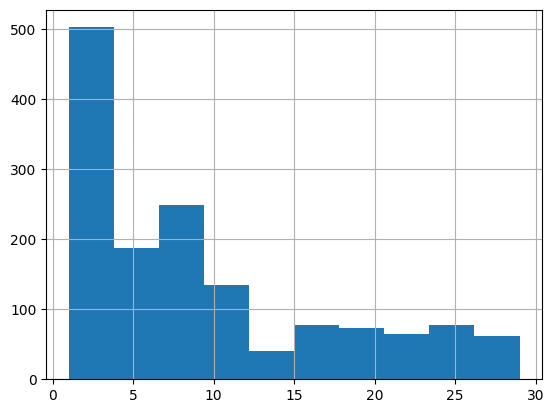

In [215]:
df.DistanceFromHome.hist(bins=10)

Принцип здесь такой же как и выше.
Для оценки использовалось экспоненциальное распределение. Параметры я считаю через встроенные функции. Подробно описывать я не буду

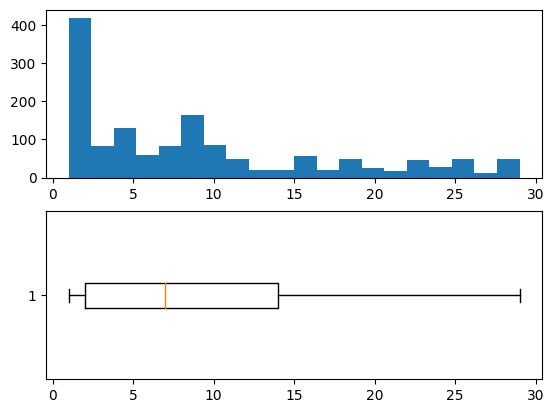

In [216]:
import matplotlib.pyplot as plt

x = df.DistanceFromHome.to_numpy()
plt.subplot(2, 1, 1)
plt.hist(x, bins=20)

plt.subplot(2,1,2)
plt.boxplot(x, vert=False)
plt.show()

In [217]:
q = {}
arr = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in arr:
    q[i] = pd.Series(np.quantile(x, i))
quantile = pd.DataFrame(q)
quantile

,0.10,0.25,0.50,0.75,0.90
0,1.0,2.0,7.0,14.0,23.0


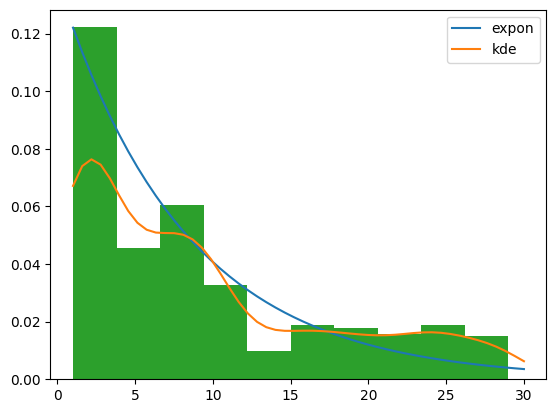

In [218]:
from scipy.stats import expon

exp = expon.fit(df.DistanceFromHome)
y = [expon.pdf(i, exp[0], exp[1]) for i in np.linspace(1,30)]

x_grid = np.linspace(1,30)
plt.plot(x_grid, y, label='expon')

density = gaussian_kde(df.DistanceFromHome.to_numpy())
plt.plot(x_grid, density(x_grid), label='kde')
plt.hist(df.DistanceFromHome, bins=10, density=True)

plt.legend()
plt.show()

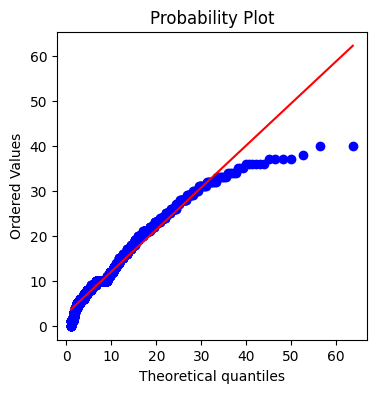

In [219]:
figure, ax = plt.subplots(1, 1, figsize=(4, 4))
scipy.stats.probplot(df.TotalWorkingYears, dist=scipy.stats.expon, sparams=(exp[0], exp[1]), plot=ax)
plt.show()

In [220]:
ydata, xdata = np.histogram(df.DistanceFromHome, bins=25, density=True)
def g(t, p0, p1):

    return expon.pdf(t, p0, p1)

p = scipy.optimize.curve_fit(g, xdata[1:], ydata)
p[0]

array([0.74981953, 0.95435349])

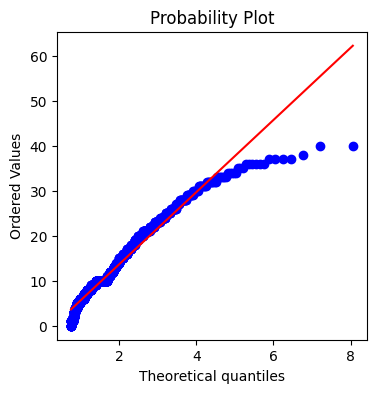

In [221]:
figure, ax = plt.subplots(1, 1, figsize=(4, 4))
scipy.stats.probplot(df.TotalWorkingYears, dist=scipy.stats.expon, sparams=(p[0][0], p[0][1]), plot=ax)
plt.show()

In [222]:
param_ks = kstest(df.DistanceFromHome, cdf='expon', args=exp)
param_log = cramervonmises(df.DistanceFromHome, cdf='expon', args=exp)
print(param_log)
print(param_ks)

CramerVonMisesResult(statistic=5.683335443138285, pvalue=5.718313600411307e-10)
KstestResult(statistic=0.17012696560241367, pvalue=1.1485974156178537e-37)


In [223]:
class Exp():
    def __init__(self, param):
        self.param = param
    def pdf(self, x):
       return expon.pdf(x, self.param[0], self.param[1])
    def cdf(self, x):
       return expon.cdf(x, self.param[0], self.param[1])

dist1 = Exp(exp)
a = NumericalInverseHermite(dist=dist1)
b = SimpleRatioUniforms(dist=dist1)
l = a.rvs(size=100)

C:\Users\User\AppData\Local\Temp\ipykernel_12372\1995752428.py:11: RuntimeWarning: [objid: SROU] 22 : mode: try finding it (numerically) => (distribution) incomplete distribution object, entry missing
  b = SimpleRatioUniforms(dist=dist1)


(array([0.1061424, 0.0734832, 0.0653184, 0.0285768, 0.0285768, 0.020412 ,
        0.020412 , 0.0040824, 0.0122472, 0.0040824, 0.0122472, 0.0040824,
        0.0081648, 0.       , 0.0040824, 0.       , 0.0040824, 0.       ,
        0.       , 0.0122472]),
 array([ 1.00050103,  3.45004063,  5.89958022,  8.34911982, 10.79865941,
        13.24819901, 15.6977386 , 18.1472782 , 20.5968178 , 23.04635739,
        25.49589699, 27.94543658, 30.39497618, 32.84451578, 35.29405537,
        37.74359497, 40.19313456, 42.64267416, 45.09221375, 47.54175335,
        49.99129295]),
 <BarContainer object of 20 artists>)

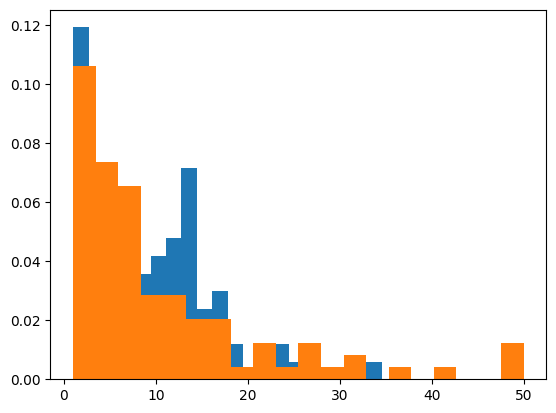

In [225]:
aa = b.rvs(size=100)
plt.hist(l, bins=20, density=True)
plt.hist(aa, bins=20, density=True)

Критерий согласия для сэмплированных данных:

In [227]:
qwe = kstest(df.DistanceFromHome, l)
qwe

KstestResult(statistic=0.1414965986394558, pvalue=0.04235705961771649)

Критерий для сэмплированных данных получается близок к 0.05